#  Reproduce Figures 1 and 2
---
_This notebook reproduces the results of Figures 1 and 2 from the paper: https://arxiv.org/abs/2108.11481_

Paper authors: S. Menary [sbmenary@gmail.com] and D. Price [darren.price@cern.ch]

Notebook author: S. Menary [sbmenary@gmail.com]

---

The aim of this notebook is to visualise our procedure for projecting physical data onto the latent space. The projected data may be described using a Gaussian mixture model (GMM). The projection is invertible, and may be configured to optimise the GMM performance.

This notebook performs several steps:
1. Load the simulated data for several values of cWtil (note that cHWB is fixed to 0 throughout)
2. Project the data onto the latent space
3. Create plots describing how this projection was performed (Figure 1)
4. Train a GMM to describe the projected data over all values of cWtil
5. Visualise the resulting model description (Figure 2)

## 1. Configuration

- Import python libraries
- Import local packages
- Configure global constants which steer the notebook
- Configure constants associated with data projection and neural network architecture

In [2]:
#========================#
#==  Import libraries  ==#
#========================#

print("Importing standard library")
import math, os, sys, time

print("Importing python data libraries")
import numpy as np
from matplotlib import cm, pyplot as plt, lines
from scipy      import stats

print("Importing third party libraries")
import dill as pickle

print("Importing custom backends")
top_dir = "/".join(os.getcwd().split("/")[:-1])
print(f"-  assuming top-level directory is {top_dir}")
sys.path.append(top_dir)
from backends.data_preparation import DataTable
from backends.density_model    import DensityModel, get_sum_gauss_density
from backends.plot             import histo_to_line
from backends.stats            import project_axes_onto_latent
from backends.utils            import make_sure_dir_exists_for_filename

from backends import density_model as density_model, VBFZ_analysis as VBFZ

Importing standard library
Importing python data libraries
Importing third party libraries
Importing custom backends
-  assuming top-level directory is /Users/Ste/PostDoc/git-with-DP/expressive_gaussian_mixture_models


In [3]:
#==================================================#
#  ==  Configure steering commands for notebook  ==#
#==================================================#

load_GMM                  = True
load_projection_functions = True
save_plots                = True


In [4]:
#===================================================#
#==  Configure target observable and input files  ==#
#===================================================#

target_observable = "Dphi_j_j" 

cWtil_vals = [0, -0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4]

input_fnames = {}
input_fnames [ 0  ] = "../Data/SM_EWK_1M_rivet_output.pickle"
input_fnames [-0.4] = "../Data/cWtil_m0p4_full_400k_rivet_output.pickle"
input_fnames [-0.3] = "../Data/cWtil_m0p3_full_400k_rivet_output.pickle"
input_fnames [-0.2] = "../Data/cWtil_m0p2_full_400k_rivet_output.pickle"
input_fnames [-0.1] = "../Data/cWtil_m0p1_full_400k_rivet_output.pickle"
input_fnames [ 0.1] = "../Data/cWtil_0p1_full_400k_rivet_output.pickle"
input_fnames [ 0.2] = "../Data/cWtil_0p2_full_400k_rivet_output.pickle"
input_fnames [ 0.3] = "../Data/cWtil_0p3_full_400k_rivet_output.pickle"
input_fnames [ 0.4] = "../Data/cWtil_0p4_full_400k_rivet_output.pickle"


In [5]:
#================================#
#==  Configure neural network  ==#
#================================#

N_G                       = 30
max_epochs                = 200
batch_size                = 1000
early_stopping_patience   = 10
early_stopping_min_delta  = 0
validation_split          = 0.3

learning_rate              = 1e-3       
learning_rate_evo_factor   = 0.5    
learning_rate_evo_patience = 2
optimiser                  = "adam"


In [6]:
#==============================================#
#==  Configure projection onto latent space  ==#
#==============================================#

proj_linear_fraction_data_space   = VBFZ.get_obs_proj_linear_fraction_data_space(target_observable)
proj_linear_fraction_latent_space = VBFZ.get_obs_proj_linear_fraction_latent_space(target_observable)
proj_num_points                   = 200

#  Structure to store details of the projection method
class ProjectionMethod :
    def __init__ (self, func_form, alpha=0., beta=0., gamma=0., load_file=None, save_file=None, load_model_dir=None, save_model_dir=None) :
        assert func_form in ["step", "gaus"]
        self.func_form      = func_form
        self.alpha          = alpha
        self.beta           = beta
        self.gamma          = gamma
        self.load_file      = load_file
        self.save_file      = save_file
        self.load_model_dir = load_model_dir
        self.save_model_dir = save_model_dir

proj_method = ProjectionMethod("step", 
                               4, 3, 1, 
                               load_file=f".proj_funcs_EWK_{target_observable}.pickle", 
                               save_file=f".proj_funcs_EWK_{target_observable}.pickle", 
                               load_model_dir=f".EWK_density_model_step_{target_observable}", 
                               save_model_dir=f".EWK_density_model_step_{target_observable}")


In [7]:
#  Data config

remove_observables = [obs for obs in VBFZ.all_observables if obs != target_observable] 
VBFZ.configure(remove_observables)


In [8]:
#===============================================#
#===  Set configuration constants for plots  ===#
#===============================================#

obs_limits = VBFZ.observable_limits[target_observable]

intervals       = []                   # set labelled vertical contours on Figure 1 (top row)
minor_intervals = []                   # set unlabelled vertical contours on Figure 1 (top row)
x_prime         = np.mean(obs_limits)  # set position of green line (bottom row)


#
#  Special config if target_observable is set to Dphi_jj
#  -  can add extra cases to configure other observables

if target_observable is "Dphi_j_j" :

    intervals = [[-np.pi      , r"$-\pi$"           ], 
                 [-3.*np.pi/4., r"$-\frac{3\pi}{4}$"], 
                 [-np.pi/2.   , r"$-\frac{\pi}{2}$" ],
                 [-np.pi/4.   , r"$-\frac{\pi}{4}$" ], 
                 [0           , "$0$"               ], 
                 [np.pi/4.    , r"$\frac{\pi}{4}$"  ],
                 [np.pi/2.    , r"$\frac{\pi}{2}$"  ], 
                 [3.*np.pi/4. , r"$\frac{3\pi}{4}$" ], 
                 [np.pi       , r"$\pi$"            ]]

    minor_intervals = [(i-16.)*np.pi/16. for i in range(32) if i % 4 != 0]

    x_prime = 0.8


##  2. Load input data

We will load the MG5 data from the filenames provided and store them in a dict. For now each table is stored as an instance of a custom DataTable object, which is designed to understand the format of our high-energy-physics data and allow some easy loading/manipulation of it. However, ultimately this data will be accessed as a 2D numpy array along with a 1D array of event weights, so other formats of data could easily be swapped in according to the details of your pipeline.

In [9]:
#==================================#
#==  Load and format input data  ==#
#==================================#

data_tables = {}
for cWtil in cWtil_vals :
    input_fname = input_fnames [cWtil]
    print(f"Creating data table for cWtil={cWtil}")
    print(f" -- events from file {input_fname}")
    data = DataTable(input_fname)
    print(f" -- Table created with {data.get_num_events()} events")
    for observable in VBFZ.all_observables :
        limits = VBFZ.observable_limits[observable]
        print(f" -- filtering observable {observable} between {limits[0]} and {limits[1]}")
        data.filter(observable, limits[0], limits[1])
        print(f" -- {data.get_num_events()} events survived")
    for observable in remove_observables :
        print(f" -- removing observable {observable}")
        data.remove_column(observable)
    data.print_summary()
    data_tables[cWtil] = data
    

Creating data table for cWtil=0
 -- events from file ../Data/SM_EWK_1M_rivet_output.pickle
 -- Table created with 1000000 events
 -- filtering observable Dphi_j_j between -3.141592653589793 and 3.141592653589793
 -- 671396 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 671396 events survived
 -- filtering observable N_gap_jets between 0 and 2
 -- 671396 events survived
 -- filtering observable N_jets between 2 and 5
 -- 671396 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 668163 events survived
 -- filtering observable m_ll between 75 and 105
 -- 651575 events survived
 -- filtering observable pT_j1 between 60 and 1200
 -- 649064 events survived
 -- filtering observable pT_j2 between 40 and 1200
 -- 647961 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 647935 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 647934 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 647934 events 

 -- Table created with 400000 events
 -- filtering observable Dphi_j_j between -3.141592653589793 and 3.141592653589793
 -- 268658 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 268658 events survived
 -- filtering observable N_gap_jets between 0 and 2
 -- 268658 events survived
 -- filtering observable N_jets between 2 and 5
 -- 268658 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 267337 events survived
 -- filtering observable m_ll between 75 and 105
 -- 260697 events survived
 -- filtering observable pT_j1 between 60 and 1200
 -- 259732 events survived
 -- filtering observable pT_j2 between 40 and 1200
 -- 259295 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 259278 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 259278 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 259278 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 256009 events survived
 -- fi

 -- 269075 events survived
 -- filtering observable Dy_j_j between 0 and 8.8
 -- 269075 events survived
 -- filtering observable N_gap_jets between 0 and 2
 -- 269075 events survived
 -- filtering observable N_jets between 2 and 5
 -- 269075 events survived
 -- filtering observable m_jj between 150 and 5000
 -- 267831 events survived
 -- filtering observable m_ll between 75 and 105
 -- 261208 events survived
 -- filtering observable pT_j1 between 60 and 1200
 -- 260174 events survived
 -- filtering observable pT_j2 between 40 and 1200
 -- 259714 events survived
 -- filtering observable pT_jj between 0 and 900
 -- 259633 events survived
 -- filtering observable pT_ll between 0 and 900
 -- 259630 events survived
 -- filtering observable rap_jj between 0 and 4.4
 -- 259630 events survived
 -- filtering observable rap_ll between 0 and 2.2
 -- 256342 events survived
 -- filtering observable theta_jj between 0 and 3.141592653589793
 -- 256342 events survived
 -- filtering observable theta_ll

##  3. Project data onto latent space

We now project data onto the latent space

In [10]:
#======================================#
#==  Project data onto latent space  ==#
#======================================#

#
#  Create a container which specifies the projection config for every observable
#    (only consider 1 observable in this notebook, but needs to be a 2D container for generality)
#
axis_configs = [[VBFZ.observable_limits[target_observable][0], 
                 VBFZ.observable_limits[target_observable][1], 
                 proj_num_points,  
                 proj_linear_fraction_data_space, 
                 proj_linear_fraction_latent_space]]

#
#  If projection functions were already calculated in a previous run, we will load them to speed things up
#  Otherwise we calculate them at a value of cWtil=0 and save them if requested
#
if (load_projection_functions) and (type(proj_method.load_file) != type(None) and (os.path.isfile(proj_method.load_file))) :
    print(f"Loading projection functions from file {proj_method.load_file}")
    proj_funcs = pickle.load(open(proj_method.load_file, "rb"))
else :
    print(f"Calculting projection functions at cWtil = 0")
    data          = data_tables[0]
    vals, weights = data_tables[0].get_observables_and_weights()
    _, proj_funcs = project_axes_onto_latent(vals, data.types, axis_configs=axis_configs, proj_funcs=None, weights=weights, 
                                             func_form=proj_method.func_form, alpha=proj_method.alpha, beta=proj_method.beta, gamma=proj_method.gamma)
    if type(proj_method.save_file) != type(None) :
        print(f"Saving projection functions to file {proj_method.save_file}")
        make_sure_dir_exists_for_filename(proj_method.save_file)
        pickle.dump(proj_funcs, open(proj_method.save_file, "wb"))


#
#  Loop over cWtil, and for each value store
#    -  the datapoints on their original space
#    -  the datapoints projected onto the latent space
#    -  their MC weights
#
observable_data, data_weights, latent_data = {}, {}, {}
for cWtil in cWtil_vals :
    data = data_tables[cWtil]
    observable_data[cWtil], data_weights[cWtil] = data.get_observables_and_weights()
    print(f"Projecting dataset for cWtil={cWtil} onto the latent space")
    latent_data[cWtil], _ = project_axes_onto_latent(observable_data[cWtil], data.types, axis_configs=axis_configs, proj_funcs=proj_funcs, weights=data_weights[cWtil])
#
#  Also find out how our major intervals transform, so we can draw their contours on the latent space
#
print(f"Projecting {len(intervals)} intervals onto the latent space")
proj_intervals = []
if len(intervals) > 0 :
    proj_intervals = project_axes_onto_latent(np.array([[i[0]] for i in intervals]), data.types, axis_configs=axis_configs, proj_funcs=proj_funcs, weights=np.ones_like(intervals))[0]
#
#  Also find out how our minor intervals transform, so we can draw their contours on the latent space
#
print(f"Projecting {len(minor_intervals)} minor intervals onto the latent space")
proj_minor_intervals = []
if len(minor_intervals) > 0 :
    proj_minor_intervals = project_axes_onto_latent(np.array([[i] for i in minor_intervals]), data.types, axis_configs=axis_configs, proj_funcs=proj_funcs, weights=np.ones_like(minor_intervals))[0]
        

Loading projection functions from file .proj_funcs_EWK_Dphi_j_j.pickle
Projecting dataset for cWtil=0 onto the latent space
Projecting dataset for cWtil=-0.4 onto the latent space
Projecting dataset for cWtil=-0.3 onto the latent space
Projecting dataset for cWtil=-0.2 onto the latent space
Projecting dataset for cWtil=-0.1 onto the latent space
Projecting dataset for cWtil=0.1 onto the latent space
Projecting dataset for cWtil=0.2 onto the latent space
Projecting dataset for cWtil=0.3 onto the latent space
Projecting dataset for cWtil=0.4 onto the latent space
Projecting 9 intervals onto the latent space
Projecting 24 minor intervals onto the latent space


In [11]:
#=======================================================================#
#==  Normalise weights of each category before fitting density model  ==#
#=======================================================================#
#
#  The sum-of-weights for each cWtil hypothesis reflects the predicted generator-lvl cross section
#  When training our density model, we do not want to give higher weight to hypotheses which predict a
#    higher cross section, therefore we will instead normalise the weights such that they sum to unity
#    for every value of cWtil. A priori this means that the density model will not prefer to describe
#    any one value of cWtil better than any other. However, note that datapoints in the "bulk" (e.g.
#    at cWtil~0) will be constrained by the data at the cWtil values on either side (e.g. at -0.1 and
#    +0.1), whereas those at the edge (e.g. at +/-0.4) will only be constrained on one side. This means
#    that we generally observe data in the bulk to be better described that at the edges. This motivates
#    providing training data at cWtil values beyond those which you expect to probe in your real data,
#    to ensure that the model is well described for all cWtil values you may observe.
#

data_weights_to_fit = {k:i/np.sum(i) for k,i in data_weights.items()}
    

##  4. Make Figure 1


In [12]:
#==========================================#
#==  Calculate curves for Fig1 (bottom)  ==#
#==========================================#
#
#  We will plot the projection function for data at the SM
#  In this cell, we calculate the curves required for plotting
#  First we retrieve the data, and the config for the projection
#
alpha, beta , gamma      = proj_method.alpha, proj_method.beta, proj_method.gamma
axmin, axmax, ax_npoints = VBFZ.observable_limits[target_observable][0], VBFZ.observable_limits[target_observable][1], proj_num_points
ax_scan_points           = np.linspace(axmin, axmax, 1+ax_npoints)
data_frac_constant       = proj_linear_fraction_data_space
latent_frac_constant     = proj_linear_fraction_latent_space
dataset   = observable_data    [0][:,0]
weights   = data_weights_to_fit[0]
ds_and_w  = np.array([(x,w) for x, w in zip(dataset, weights) if (x>axmin and x<axmax)])
dataset, weights = [x[0] for x in ds_and_w], [x[1] for x in ds_and_w]
weights   = weights / np.sum(weights)
func_form = proj_method.func_form
#
#  Now we find the response curve on the data space
#
print("Getting data c.d.f.")
data_cdf = []
for A in ax_scan_points :
    sys.stdout.write(f"\rScan point is: {A:.4f}  ----------")
    data_cdf.append(np.sum([w for x,w in zip(dataset, weights) if x < A]))
data_cdf          = np.array(data_cdf)
data_constant_cdf = (ax_scan_points - axmin) / (axmax - axmin)
data_combined_cdf = data_frac_constant*data_constant_cdf + (1-data_frac_constant)*data_cdf
#
#  Now we find the response curve on the latent space
#  Note that this depends on the functional form chosen for the target distribution
#  Currently options for "step" and "gaus" are implemented
#  Modify backends.stats.py:get_special_encoding_constants_for_axis to implement alternatives and
#    include them in this cell too
#
print("\nGetting latent c.d.f.")
latent_space_x  = np.linspace(-5, 5, 201)
latent_constant_cdf    = (latent_space_x - np.min(latent_space_x)) / (np.max(latent_space_x) - np.min(latent_space_x))
if func_form == "step" :
    latent_space_y = 1. / (1 + np.exp((latent_space_x-beta)*alpha-gamma)) / (1 + np.exp(-(latent_space_x+beta)*alpha-gamma))
    target_cdf     = np.array([np.sum(latent_space_y[:i+1]) for i in range(len(latent_space_y))])
    target_cdf     = target_cdf / target_cdf[-1]
    target_cdf[0]  = 0.
elif func_form == "gaus" :
    latent_space_y = stats.norm.pdf(latent_space_x)
    target_cdf     = stats.norm.cdf(latent_space_x)
    target_cdf     = (target_cdf - np.min(target_cdf)) / (np.max(target_cdf) - np.min(target_cdf))
else :
    raise NotImplementedError(f"Projection func form '{whitened_func_form}' not recognised")
latent_combined_cdf = latent_frac_constant*latent_constant_cdf + (1-latent_frac_constant)*target_cdf
            
print("Done")


Getting data c.d.f.
Scan point is: 3.1416  -----------
Getting latent c.d.f.
Done


In [13]:
#
#  For the green dashed line, we must resolve y_prime = Q_x(x_prime) and Q_u^-1(y_prime)
#
y_prime = np.interp(x_prime, ax_scan_points     , data_combined_cdf)
u_prime = np.interp(y_prime, latent_combined_cdf, latent_space_x   )
print(f"x_prime = {x_prime:.4f}")
print(f"y_prime = {y_prime:.4f}")
print(f"u_prime = {u_prime:.4f}")

x_prime = 0.8000
y_prime = 0.6049
u_prime = 0.6569


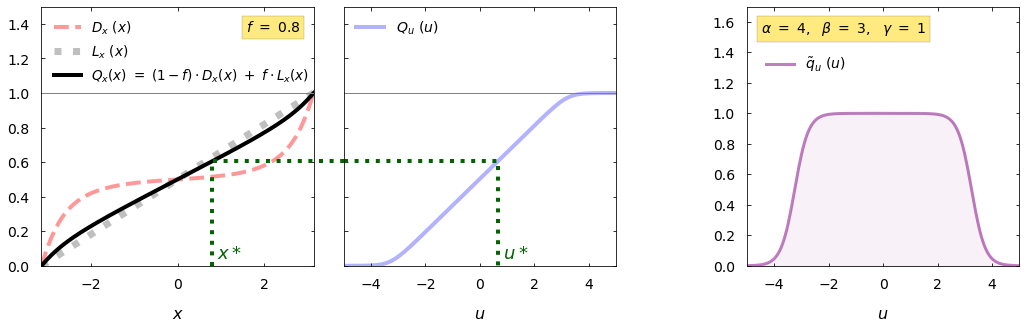

In [33]:
#==========================#
#==  Plot Fig1 (bottom)  ==#
#==========================#
#
#  Create figure object
# 
fig    = plt.figure(figsize=(14., 0.8*4.5))
#
#  Plot left-hand axes
#
ax     = fig.add_axes([0.01, 0.01, 0.27, 1.])
ax.plot(ax_scan_points, data_cdf         , "-", linestyle="--", lw=4, c="r"   , alpha=0.4, label="$D_x~(x)$")
ax.plot(ax_scan_points, data_constant_cdf, "-", linestyle=":" , lw=7, c="grey", alpha=0.5, label="$L_x~(x)$")
ax.plot(ax_scan_points, data_combined_cdf, "-", linestyle="-" , lw=4, c="k"   , label="$Q_x(x) ~=~ (1-f)\cdot D_x(x) ~+~ f\cdot L_x(x)$")
ax.axhline(1, linestyle="-", color="grey", linewidth=1)
ax.set_xlim([ax_scan_points[0], ax_scan_points[-1]])
ax.set_ylim([0        , 1.5])
ax.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14, pad=12)
ax.set_xlabel("$x$"   , fontsize=16, labelpad=15)
ax.legend(loc="upper left", fontsize=13.5, frameon=False)
ax.plot([x_prime, x_prime, 2*ax_scan_points[-1]-ax_scan_points[0]], [0, y_prime, y_prime], ":", c="darkgreen", lw=4, clip_on=False)
ax.text(x_prime, 0.02, " $x*$", ha="left", va="bottom", fontsize=18, c="darkgreen")
ax.text(0.95, 0.95, f"$f~=~{proj_linear_fraction_data_space:.1f}$", ha="right", va="top", fontsize=14, transform=ax.transAxes, bbox=dict(facecolor="gold", alpha=0.5, linewidth=0.3))
#
#  Plot middle axes
#
ax     = fig.add_axes([0.31, 0.01, 0.27, 1.])
ax.plot(latent_space_x, latent_combined_cdf, "-", linestyle="-" , lw=4, c="b", label="$Q_u~(u)$", alpha=0.3)
ax.axhline(1, linestyle="-", color="grey", linewidth=1)
ax.set_xlim([latent_space_x[0], latent_space_x[-1]])
ax.set_ylim([0        , 1.5])
ax.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14, pad=12)
ax.get_yaxis().set_ticklabels([])
ax.set_xlabel("$u$"   , fontsize=16, labelpad=15)
ax.legend(loc="upper left", fontsize=14, frameon=False)
ax.plot([latent_space_x[0], u_prime, u_prime], [y_prime, y_prime, 0], ":", c="darkgreen", lw=4, clip_on=False)
ax.text(u_prime, 0.02, " $u*$", ha="left", va="bottom", fontsize=18, c="darkgreen")
#
#  Plot right-hand axes
#  
ax     = fig.add_axes([0.71, 0.01, 0.27, 1.])
ax.plot(latent_space_x, latent_space_y, "-", linestyle="-", lw=3, c="purple", label=r"${\tilde q}_u~(u)$", alpha=0.5)
ax.fill_between(latent_space_x, np.zeros_like(latent_space_x), latent_space_y, color="purple", alpha=0.05)
ax.set_xlim([latent_space_x[0], latent_space_x[-1]])
ax.set_ylim([0, 1.7*np.max(latent_space_y)])
ax.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14, pad=12)
ax.set_xlabel("$u$", fontsize=16, labelpad=15)
ax.legend(loc=(0.05, 0.72), fontsize=14, frameon=False) 
ax.text(0.05, 0.95, r"$\alpha~="+f"~{alpha:.0f}"+r",~~\beta ~="+f"~{beta :.0f}"+r",~~\gamma~="+f"~{gamma:.0f}$", ha="left", va="top", fontsize=14, transform=ax.transAxes, bbox=dict(facecolor="gold", alpha=0.5, linewidth=0.3))
#
#  Save and show figure
#
if save_plots :
    save_fname = f"figures/Figure1/Fig1_bottom_{target_observable}.pdf"
    make_sure_dir_exists_for_filename(save_fname)
    plt.savefig(save_fname, bbox_inches="tight")
plt.show()


Physical distribution with data between -3.1416 and 3.1416
 Latent  distribution with data between -4.9976 and 4.9946


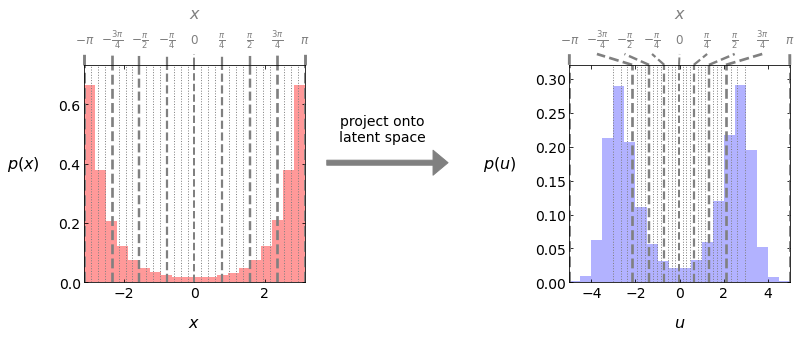

In [15]:
#=======================#
#==  Plot Fig1 (top)  ==#
#=======================#
#
#  Create figure object
#
fig = plt.figure(figsize=(10, 4))
#
#  Print details of the distribution extremes
#
print(f"Physical distribution with data between {np.min(observable_data[0]):.4f} and {np.max(observable_data[0]):.4f}")
print(f" Latent  distribution with data between {np.min(latent_data    [0]):.4f} and {np.max(latent_data    [0]):.4f}")
#
#  Plot left-hand axis
#
ax   = fig.add_subplot(1, 2, 1)
bins = np.linspace(VBFZ.observable_limits[target_observable][0], VBFZ.observable_limits[target_observable][1], 21)
vals, _, _ = ax.hist(observable_data[0], weights=data_weights_to_fit[0], bins=bins, density=True, color="r", alpha=0.4)
hmax = 1.1 * np.max(vals)
ax.set_xlim([bins[0], bins[-1]])
ax.set_ylim([0      , hmax])
ax.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14)
ax.set_ylabel("$p(x)$", fontsize=16, labelpad=35, rotation=0)
ax.set_xlabel("$x$"   , fontsize=16, labelpad=15)
ax.text(0.5, 1.2, "x", transform=ax.transAxes, c="grey", ha="center", va="bottom", fontsize=16, style="italic")
#
#  Draw major interval lines
#
for idx, i in enumerate(intervals) :
    lw = 2.+2*np.fabs(math.floor(len(intervals)/2.)-idx)/len(intervals)
    ax.axvline(i[0], linestyle="--", c="grey", linewidth=lw)
    ax.text(i[0], 1.1*hmax, i[1], c="grey", fontsize=12, ha="center")
    ax.plot([i[0], i[0]], [hmax, 1.05*hmax], linestyle="--", c="grey", linewidth=lw, clip_on=False)
#
#  Draw minor interval lines
#
for i in minor_intervals :
    ax.axvline(i, linestyle=":", c="grey", linewidth=1.)
#
#  Plot right-hand axis
#
ax   = fig.add_subplot(1, 2, 2)
edge = np.max(np.fabs(latent_data[0]))
bins = np.linspace(-edge, edge, 21)
vals , _, _ = ax.hist(latent_data[0], weights=data_weights_to_fit[0], bins=bins, density=True, color="b", alpha=0.3)
hmax = 1.1 * np.max(vals)
ax.set_xlim([np.min(np.concatenate([bins, [i[0] for i in proj_intervals]])), np.max(np.concatenate([bins, [i[0] for i in proj_intervals]]))])
ax.set_ylim([0      , hmax])
ax.tick_params(axis="both", right=True, top=True, direction="in", labelsize=14)
ax.set_ylabel("$p(u)$", fontsize=16, labelpad=35, rotation=0)
ax.set_xlabel("$u$"   , fontsize=16, labelpad=15)
ax.text(0.5, 1.2, "x", transform=ax.transAxes, c="grey", ha="center", va="bottom", fontsize=16, style="italic")
#
#  Draw major interval lines
#
for idx, (i, wi) in enumerate(zip(intervals, proj_intervals)) :
    lw = 2.+2*np.fabs(math.floor(len(intervals)/2.)-idx)/len(intervals)
    ax.axvline(wi[0], linestyle="--", c="grey", linewidth=lw)
    xlo, xhi, xrange = bins[0], bins[-1], bins[-1] - bins[0]
    label_pos        = xlo + xrange*(idx/(len(intervals)-1.)), 1.1*hmax, 1.05*hmax
    line_pos         = wi[0], hmax
    ax.text(label_pos[0], label_pos[1], i[1], c="grey", fontsize=12, ha="center")
    ax.plot([line_pos[0], label_pos[0]], [line_pos[1], label_pos[2]], linestyle="--", c="grey", linewidth=lw, clip_on=False)
#
#  Draw minor interval lines
#     
for wi in proj_minor_intervals :
    ax.axvline(wi, linestyle=":", c="grey", linewidth=1.)
#
#  Annotate with text and arrow in between axes
#
ax.text(-0.85, 0.65, "project onto\nlatent space", transform=ax.transAxes, ha="center", fontsize=14)
ax.annotate("", xy=(-0.55, 0.55), xycoords  ="axes fraction",
            xytext=(-1.1 , 0.55), textcoords="axes fraction",
            arrowprops=dict(width=5, headwidth=25, headlength=15, facecolor="grey", edgecolor="grey"))
#
#  Adjust axes positions
#
plt.subplots_adjust(wspace=1.2, left=0.01, right=0.99)
#
#  Save and show figure
#
if save_plots :
    save_fname = f"figures/Figure1/Fig1_top_{target_observable}.pdf"
    make_sure_dir_exists_for_filename(save_fname)
    plt.savefig(save_fname, bbox_inches="tight")
plt.show()


##  5. Train a GMM to describe the data on the latent space



In [16]:
#========================================================#
#==  Load model if requested, otherwise build and fit  ==#
#========================================================#
#
#  Load GMM if requested
#
create_new_model = True
if load_GMM : 
    load_model_dir   = proj_method.load_model_dir
    if type(load_model_dir) != type(None) :
        print(f"Attempting to load model from directory {load_model_dir}")
        if os.path.exists(load_model_dir) :
            GMM = DensityModel.from_dir(load_model_dir)
            print(f"Model loaded from directory {load_model_dir}")
            create_new_model = False
        else :
            print(f"Warning: load_model_dir '{load_model_dir}' does not exist")
    else :
        print(f"Warning: load_GMM set to True but no filename provided, a new model will be created")
#
#  If model not loaded, create a new one and fit it to the data
#
if create_new_model :
    print(f"Creating new model {load_model_dir}")
    #
    #   Figure out the limits of the observable
    #
    range_limits = {}
    all_data   = np.concatenate([item.flatten() for c,item in latent_data.items()])
    imin, imax = np.min(all_data), np.max(all_data)
    irange     = imax - imin
    range_limits[0] = [imin + 0.5*irange/N_G, imax - 0.5*irange/N_G] 
    #
    #   Create GMM
    #
    GMM = DensityModel(name = "GMM", 
                       num_gaussians      = N_G, 
                       num_conditions     = 1, 
                       num_observables    = 1, 
                       types              = [float],
                       int_limits         = {},
                       verbose            = True,
                       learning_rate      = learning_rate,
                       optimiser          = optimiser,
                       observables_limits = range_limits,
                       A1                 = 50,
                       A2                 = 0,
                       B1                 = 50,
                       B2                 = 20,
                       C_float            = 2,
                       D2                 = 3,
                       gauss_mean_scale   = 1./4. ,
                       gauss_frac_scale   = 1./4. ,
                       gauss_sigma_scale  = 1./4. ,
                       gauss_width_factor = 1./8.)
    #
    #  Make sure the initial conditions do not predict vanishing likelihood for any datapoint
    #
    GMM.ensure_valid_over_dataset (latent_data, data_weights_to_fit)
    #
    #   Fit GMM
    #
    GMM.fit(latent_data, 
            data_weights_to_fit,
            observable                 = 0,
            max_epochs_per_observable  = max_epochs,
            early_stopping_patience    = early_stopping_patience,
            early_stopping_min_delta   = early_stopping_min_delta,
            validation_split           = validation_split,
            batch_size_per_observable  = batch_size,
            learning_rate_evo_factor   = learning_rate_evo_factor,
            learning_rate_evo_patience = learning_rate_evo_patience)


Attempting to load model from directory .EWK_density_model_step_Dphi_j_j
Model loaded from directory .EWK_density_model_step_Dphi_j_j


In [17]:
#========================================================#
#==  Save model if requested, otherwise build and fit  ==#
#========================================================#
#
#  Save the GMM if requested (only if a new model was created)
#
save_model_dir = proj_method.save_model_dir
if create_new_model or (load_model_dir != save_model_dir) :
    if type(save_model_dir) != type(None) :
        print(f"Attempting to save model to directory {save_model_dir}")
        make_sure_dir_exists_for_filename(save_model_dir)
        GMM.save_to_dir(save_model_dir)
        print(f"Model saved to directory {save_model_dir}")
        

##  6. Make Figure 2

In [18]:
#============================================#
#==  Define some plotting helper functions ==#
#============================================#
#
#  Create colour map allowing us to plot Gaussian modes in continuous colour spectrum
#
newcolors = cm.get_cmap('brg', N_G)(np.linspace(0, 1, N_G))


In [19]:
#
#  Method to extract Gaussian parameters from a GMM, so we can plot the modes individually
#
def get_gauss_params (gmm, c) :
    """return the Gaussian fracs, means and sigmas given a GMM: gmm and a value cWtil: c"""
    params = gmm.likelihood_models[0].get_gauss_params([c])[0]
    fracs  = params[:N_G]
    means  = params[N_G:2*N_G]
    sigmas = params[2*N_G:3*N_G]
    return fracs, means, sigmas


In [20]:
#
#  Method to plot each of the columns of Figure 2 (all 3 axes) for a given values of c
#
def draw_column (ax_top, ax_middle, ax_bottom, c, labels=True) :
    #
    #  Get data
    #
    ds_SM, weights_SM = latent_data[0][:,0], data_weights_to_fit[0]
    ds_c , weights_c  = latent_data[c][:,0], data_weights_to_fit[c]
    #
    #  Get bins
    #
    bins      = np.linspace(-5, 5, 41)
    binwidths = bins[1:] - bins[:-1]
    #
    #  Draw histogram of MG5 data
    #
    hist_entries , _  = np.histogram(ds_c, weights=weights_c          , bins=bins)
    hist_variance, _  = np.histogram(ds_c, weights=weights_c*weights_c, bins=bins)
    hist_errors       = np.sqrt(hist_variance)
    histx, histy, histey = histo_to_line(bins, hist_entries/binwidths, hist_errors/binwidths)
    ax_top.plot(histx, histy, "-", c="darkgrey")
    ax_top.fill_between(histx, histy-histey, histy+histey, color="darkgrey", alpha=0.6)
    ax_top.fill_between(histx, 0, histy, color="darkgrey", alpha=0.2)
    #
    #  Draw density model
    #
    x, y_c, y_SM, int_c, int_SM = np.linspace(-5, 5, 501), 0., 0., 0., 0.
    fracs_c , means_c , sigmas_c  = get_gauss_params(GMM, c)
    fracs_SM, means_SM, sigmas_SM = get_gauss_params(GMM, 0)
    for i in range(N_G) :
        yp_c   = fracs_c [i]*stats.norm.pdf(x, means_c [i], sigmas_c [i])
        yp_SM  = fracs_SM[i]*stats.norm.pdf(x, means_SM[i], sigmas_SM[i])
        y_c    += yp_c
        y_SM   += yp_SM
        int_c  = int_c  + np.array([fracs_c [i]*(stats.norm.cdf(bins[j+1], means_c [i], sigmas_c [i])-stats.norm.cdf(bins[j], means_c [i], sigmas_c [i]))/(bins[j+1]-bins[j]) for j in range(len(bins)-1)])
        int_SM = int_SM + np.array([fracs_SM[i]*(stats.norm.cdf(bins[j+1], means_SM[i], sigmas_SM[i])-stats.norm.cdf(bins[j], means_SM[i], sigmas_SM[i]))/(bins[j+1]-bins[j]) for j in range(len(bins)-1)])
        ax_top.plot(x, yp_c, c=newcolors[i], linewidth=0.6, linestyle="-")
    ax_top.plot(x, y_c, c="k", linewidth=4, linestyle="--", label=r"$p_\phi(u|{\tilde c}_W)$")
    #
    #  Draw ratio-to-SM panel
    #
    rat_x, rat_y, rat_ey = histo_to_line(bins, hist_entries/binwidths/int_SM, hist_errors/binwidths/int_SM)
    ax_bottom.fill_between(rat_x, 1, rat_y, color="darkgrey", alpha=0.2)
    ax_bottom.fill_between(rat_x, rat_y-rat_ey, rat_y+rat_ey, color="darkgrey", alpha=0.6)
    ax_bottom.plot(rat_x, rat_y, "-", c="darkgrey")
    ax_bottom.plot(x, y_c/y_SM, "--", c="k", lw=3)
    ax_bottom.axhline(1.40, linestyle=":" , c="grey", linewidth=1)
    ax_bottom.axhline(1.20, linestyle=":" , c="grey", linewidth=1)
    ax_bottom.axhline(0.83, linestyle=":" , c="grey", linewidth=1)
    ax_bottom.axhline(0.71, linestyle=":" , c="grey", linewidth=1)
    #
    #  Draw ratio-to-c panel
    #
    rat_x, rat_y, rat_ey = histo_to_line(bins, hist_entries/binwidths/int_c, hist_errors/binwidths/int_c)
    ax_middle.fill_between(rat_x, 1, rat_y, color="darkgrey", alpha=0.2)
    ax_middle.fill_between(rat_x, rat_y-rat_ey, rat_y+rat_ey, color="darkgrey", alpha=0.6)
    ax_middle.plot(rat_x, rat_y, "-", c="darkgrey")
    ax_middle.axhline(1, ls="--", c="k", lw=3)
    ax_middle.axhline(0.90, linestyle=":" , c="grey", linewidth=1)
    ax_middle.axhline(0.95, linestyle=":" , c="grey", linewidth=1)
    ax_middle.axhline(1.05, linestyle=":" , c="grey", linewidth=1)
    ax_middle.axhline(1.10, linestyle=":" , c="grey", linewidth=1)
    #
    #  Format axes
    #
    ax_top   .set_xlim([-5, 5])
    ax_bottom.set_xlim([-5, 5])
    ax_middle.set_xlim([-5, 5])
    ax_top   .set_ylim([2e-3 , 2 ])
    ax_bottom.set_ylim([1/1.7, 1.7 ])
    ax_middle.set_ylim([1/1.16, 1.16])
    ax_top   .set_yscale("log")
    ax_bottom.set_yscale("log")
    ax_middle.set_yscale("log")
    ax_top   .tick_params(which="both", axis="both", right=True, top=True, direction="in", labelsize=15, pad=10)
    ax_bottom.tick_params(which="both", axis="both", right=True, top=True, direction="in", labelsize=15, pad=10)
    ax_middle.tick_params(which="both", axis="both", right=True, top=True, direction="in", labelsize=15, pad=10)
    ax_top   .yaxis.set_ticklabels([])
    ax_bottom.yaxis.set_ticks([0.71, 0.83, 1, 1.20, 1.40])
    ax_bottom.yaxis.set_ticklabels([], minor=True)
    ax_bottom.yaxis.set_ticklabels([])
    ax_middle.yaxis.set_ticks([0.90, 0.95, 1, 1.05, 1.1])
    ax_middle.yaxis.set_ticklabels([], minor=True)
    ax_middle.yaxis.set_ticklabels([])
    if labels :
        ax_bottom.yaxis.set_ticklabels(["-29%", "-17%", "0", "+20%", "+40%"])
        ax_middle.yaxis.set_ticklabels(["-10%", "-5%", "0", "+5%", "+10%"])
        ax_top   .yaxis.set_ticks([1e0, 1e-1, 1e-2])
        ax_top   .yaxis.set_ticklabels(["$10^0$", "$10^{-1}$", "$10^{-2}$"])
        ax_top   .set_ylabel(r"$p(u|{\tilde c}_W)$", fontsize=20, rotation=0, labelpad=60)
        ax_bottom.set_ylabel("Ratio to\n"+r"$p_\phi(u|0)$", fontsize=20, rotation=0, labelpad=60, va="center")
        ax_middle.set_ylabel("Ratio to\n"+r"$p_\phi(u|{\tilde c}_W)$", fontsize=20, rotation=0, labelpad=60, va="center")
    #
    #  Draw c-label and legend
    #
    ax_top.text(1, 1, r"${\tilde c}_W = "+f"{c:.1f}$", fontsize=21, weight="bold", style="italic", transform=ax_top.transAxes, ha="right", va="top", bbox=dict(facecolor='white', edgecolor='k', pad=6.0, lw=1))
    ax_bottom.set_xlabel("u", fontsize=19, labelpad=30)
    if labels :
        leg_proxy  = [plt.Rectangle((0,0),1,1,fc="grey",ec="darkgrey",lw=2,ls="-",alpha=0.6),
                      lines.Line2D([], [], color='black' , linestyle='--', lw=5, alpha=1),
                      plt.Rectangle((0,0),1,1,fc="none",lw=0,ls="-",alpha=0)]
        leg_labels = ["MG5 events", r"$p_{\phi}(u|{\tilde c}_W)$", r"  Components of $p_{\phi}(u|{\tilde c}_W)$"]
        ax_top.legend(leg_proxy, leg_labels, loc=(0, 1.05), frameon=False, edgecolor="white", facecolor="white", ncol=3, fontsize=19)
        
        test_colors = cm.get_cmap('brg', 5)(np.linspace(0, 1, 5))
        ax_top.annotate('', xy=(1.55, 1.11), xytext=(1.62, 1.19), xycoords=ax_top.transAxes, textcoords=ax_top.transAxes, arrowprops=dict(color=test_colors[0], lw=1.3, arrowstyle="-"), annotation_clip=False)
        ax_top.annotate('', xy=(1.59, 1.11), xytext=(1.66, 1.19), xycoords=ax_top.transAxes, textcoords=ax_top.transAxes, arrowprops=dict(color=test_colors[1], lw=1.3, arrowstyle="-"), annotation_clip=False)
        ax_top.annotate('', xy=(1.63, 1.11), xytext=(1.70, 1.19), xycoords=ax_top.transAxes, textcoords=ax_top.transAxes, arrowprops=dict(color=test_colors[2], lw=1.3, arrowstyle="-"), annotation_clip=False)
        ax_top.annotate('', xy=(1.67, 1.11), xytext=(1.74, 1.19), xycoords=ax_top.transAxes, textcoords=ax_top.transAxes, arrowprops=dict(color=test_colors[3], lw=1.3, arrowstyle="-"), annotation_clip=False)
        ax_top.annotate('', xy=(1.71, 1.11), xytext=(1.78, 1.19), xycoords=ax_top.transAxes, textcoords=ax_top.transAxes, arrowprops=dict(color=test_colors[4], lw=1.3, arrowstyle="-"), annotation_clip=False)


In [21]:
#
#  Method to create Figure 2
#
def create_figure_2 (savefig=None) :
    
    c_ref1, c_ref2 = np.min(cWtil_vals), np.max(cWtil_vals)
    
    fig = plt.figure(figsize=(11, 8))
    ax_top_lft = fig.add_axes([0.00, 0.60, 0.31, 0.40])
    ax_top_mid = fig.add_axes([0.33, 0.60, 0.31, 0.40])
    ax_top_rgt = fig.add_axes([0.66, 0.60, 0.31, 0.40])
    ax_mid_lft = fig.add_axes([0.00, 0.30, 0.31, 0.30])
    ax_mid_mid = fig.add_axes([0.33, 0.30, 0.31, 0.30])
    ax_mid_rgt = fig.add_axes([0.66, 0.30, 0.31, 0.30])
    ax_bot_lft = fig.add_axes([0.00, 0.00, 0.31, 0.30])
    ax_bot_mid = fig.add_axes([0.33, 0.00, 0.31, 0.30])
    ax_bot_rgt = fig.add_axes([0.66, 0.00, 0.31, 0.30])
    
    draw_column(ax_top_lft, ax_mid_lft, ax_bot_lft, c_ref1, labels=True )
    draw_column(ax_top_mid, ax_mid_mid, ax_bot_mid, 0     , labels=False)
    draw_column(ax_top_rgt, ax_mid_rgt, ax_bot_rgt, c_ref2, labels=False)
    
    if type(savefig) is str :
        make_sure_dir_exists_for_filename(savefig)
        plt.savefig(savefig, bbox_inches="tight")
    plt.show()
    

W1130 18:29:34.892227 4495932928 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_v1.py:2070: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


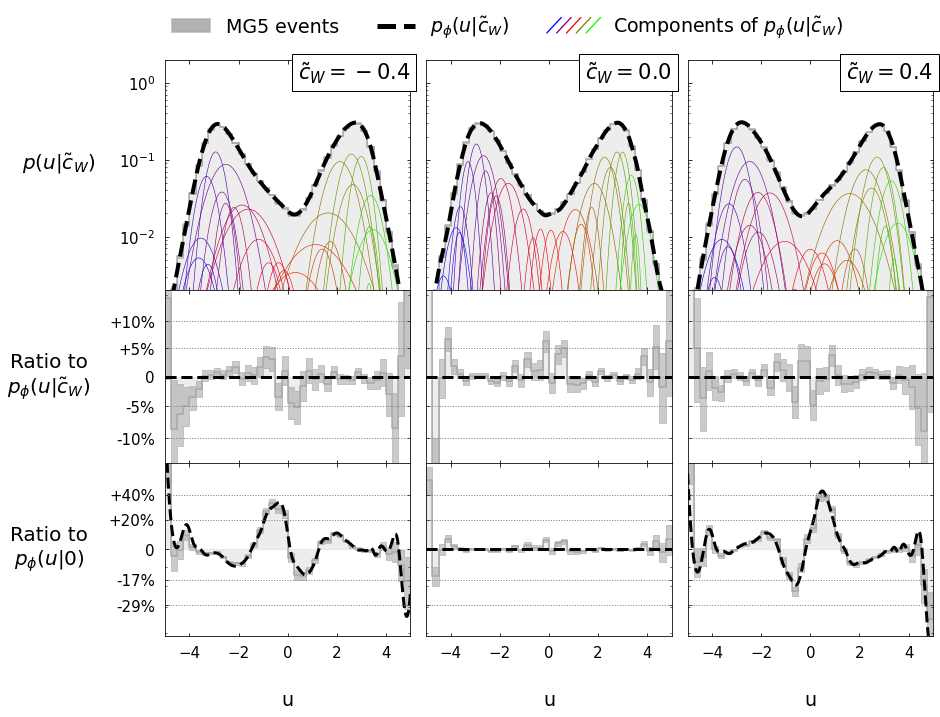

In [22]:
#
#  Plot Figure 2
#
create_figure_2(savefig=f"figures/Figure2/Fig2_{target_observable}.pdf")
